In [2]:
import pandas as pd

df = pd.read_parquet('/Users/plinphon/HSclasses/Y3M04_MLApp/hw1/data/test.parquet')

print(df.head())

print(df.info())

          city_name  position_in_request                 product_category  \
0   Nizhny Novgorod                  2.0     Dumplings with pork and beef   
1     Yekaterinburg                  7.0                     Turkey thigh   
2            Moscow                 51.0                   Korean carrots   
3  Saint Petersburg                 13.0     Dumplings with pork and beef   
4   Nizhny Novgorod                 84.0  Protein cookies without soufflé   

             product_id                                      product_image  \
0  14257006278661848651  https://avatars.mds.yandex.net/get-grocery-goo...   
1   4633212444425223945  https://avatars.mds.yandex.net/get-grocery-goo...   
2  13145627882753640389  https://avatars.mds.yandex.net/get-grocery-goo...   
3   1737649414380729500  https://avatars.mds.yandex.net/get-grocery-goo...   
4  12772894388788908958  https://avatars.mds.yandex.net/get-grocery-goo...   

                                        product_name            requ

Data covers from 2024-01-02 00:03:06 to 2024-02-02 17:34:51


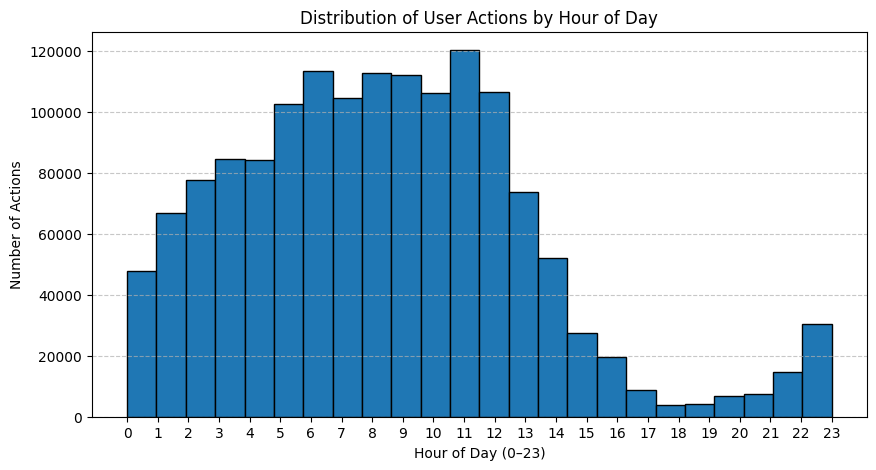

In [3]:

import matplotlib.pyplot as plt

df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

print(f"Data covers from {df['datetime'].min()} to {df['datetime'].max()}")

#plot histogram by hour of day
plt.figure(figsize=(10, 5))
df['hour'] = df['datetime'].dt.hour
plt.hist(df['hour'], bins=24, edgecolor='black')
plt.title('Distribution of User Actions by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Actions')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
print(df['source_type'].describe())
print(df['source_type'].value_counts())
print(df['source_type'].dtype)

count       14758634
unique            12
top       ST_Catalog
freq         6449005
Name: source_type, dtype: object
source_type
ST_Catalog                6449005
ST_Search                 3677848
ST_Upsale                 1679542
ST_Feed                   1169093
ST_ItemPageCarousel        493774
ST_SearchComplementRec     367375
ST_Uplift                  260406
ST_PreviousBuyHub          190337
ST_SearchStartRec          143089
ST_OnClickDelivery         132438
ST_CheckoutUpsale          124306
ST_PreviousBuyCarousel      71421
Name: count, dtype: int64
object


In [7]:
print(df['action_type'].describe())
print(df['action_type'].value_counts())
print(df['action_type'].dtype)

count     14955865
unique           4
top        AT_View
freq      14252383
Name: action_type, dtype: object
action_type
AT_View          14252383
AT_CartUpdate      279010
AT_Click           227241
AT_Purchase        197231
Name: count, dtype: int64
object


In [20]:
import duckdb

FILL_VALUE = 0
DATA_DIR = '/Users/plinphon/HSclasses/Y3M04_MLApp/hw1/data/'

In [35]:
duckdb.sql(
f"""
WITH
    actions as (
        SELECT
        user_id,
        source_type,
        product_category,
        product_id as item_id,
        request_id,
        action_type,
        position_in_request,
        make_timestamp(timestamp * 1000000) as timestamp,
        date_trunc('day', make_timestamp(timestamp * 1000000)) as day,
        date_part('hour', make_timestamp(timestamp * 1000000)) as hour,
        date_part('dow', make_timestamp(timestamp * 1000000)) as day_of_week,
        row_number() over () as idx
    FROM '{DATA_DIR}/train.parquet'
    WHERE action_type IN ('AT_CartUpdate', 'AT_View', 'AT_Click')
    ),
    

    -- USER FEATURES 

    user_windows as (
        SELECT
            idx,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) over rolling_w as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) over rolling_w as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) over rolling_w as clicks,
            count(distinct (case when action_type = 'AT_CartUpdate' then request_id end)) over rolling_w as num_requests_with_cart_update,
            count(distinct request_id) over rolling_w as total_requests,
            count(distinct day) over rolling_w as active_days,
            count(distinct item_id) over rolling_w as unique_items_viewed,
            count(distinct product_category) over rolling_w as unique_categories,
        FROM actions
        WINDOW rolling_w as (
            PARTITION BY user_id
            ORDER BY day ASC
            RANGE BETWEEN UNBOUNDED PRECEDING AND INTERVAL 1 DAYS PRECEDING
        )
    ),
    user_features as (
        SELECT
            idx,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as user_cart_update_turn_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as user_click_turn_rate,
            num_requests_with_cart_update / CASE WHEN total_requests = 0 THEN 1 ELSE total_requests END as user_conversion_rate,
            cart_updates::FLOAT as user_total_cart_updates,
            views::FLOAT as user_total_views,
            clicks::FLOAT as user_total_clicks,
            active_days::FLOAT as user_active_days,
            unique_items_viewed::FLOAT as user_unique_items,
            unique_categories::FLOAT as user_unique_categories,
            views / CASE WHEN active_days = 0 THEN 1 ELSE active_days END as user_views_per_day,
            cart_updates / CASE WHEN active_days = 0 THEN 1 ELSE active_days END as user_cart_updates_per_day
        FROM user_windows
    ),
    

    -- ITEM FEATURES 

    item_windows as (
        SELECT
            idx,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) over rolling_w as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) over rolling_w as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) over rolling_w as clicks,
            count(distinct (case when action_type = 'AT_CartUpdate' then request_id end)) over rolling_w as num_requests_with_cart_update,
            count(distinct request_id) over rolling_w as total_requests,
            count(distinct user_id) over rolling_w as unique_users,
            count(distinct day) over rolling_w as days_since_first_view,
        FROM actions
        WINDOW rolling_w as (
            PARTITION BY item_id
            ORDER BY day ASC
            RANGE BETWEEN UNBOUNDED PRECEDING AND INTERVAL 1 DAYS PRECEDING
        )
    ),
    item_features as (
        SELECT
            idx,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as item_cart_update_turn_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as item_click_turn_rate,
            num_requests_with_cart_update / CASE WHEN total_requests = 0 THEN 1 ELSE total_requests END as item_conversion_rate,
            cart_updates::FLOAT as item_total_cart_updates,
            views::FLOAT as item_total_views,
            clicks::FLOAT as item_total_clicks,
            unique_users::FLOAT as item_unique_users,
            views / CASE WHEN unique_users = 0 THEN 1 ELSE unique_users END as item_views_per_user,
            cart_updates / CASE WHEN days_since_first_view = 0 THEN 1 ELSE days_since_first_view END as item_cart_updates_per_day
        FROM item_windows
    ),
    

    -- CATEGORY FEATURES

    category_windows as (
        SELECT
            idx,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) over rolling_w as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) over rolling_w as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) over rolling_w as clicks,
        FROM actions
        WINDOW rolling_w as (
            PARTITION BY product_category
            ORDER BY day ASC
            RANGE BETWEEN UNBOUNDED PRECEDING AND INTERVAL 1 DAYS PRECEDING
        )
    ),
    category_features as (
        SELECT
            idx,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as category_cart_update_turn_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as category_click_turn_rate
        FROM category_windows
    ),
    

    -- SOURCE TYPE FEATURES

    source_windows as (
        SELECT
            idx,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) over rolling_w as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) over rolling_w as views,
        FROM actions
        WINDOW rolling_w as (
            PARTITION BY source_type
            ORDER BY day ASC
            RANGE BETWEEN UNBOUNDED PRECEDING AND INTERVAL 1 DAYS PRECEDING
        )
    ),
    source_features as (
        SELECT
            idx,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as source_cart_update_turn_rate
        FROM source_windows
    ),
    
    -- USER-ITEM INTERACTION FEATURES

    user2item_windows as (
        SELECT
            idx,
            timestamp,
            max(case when action_type = 'AT_CartUpdate' then timestamp end) over rolling_w as last_cart_update_timestamp,
            max(case when action_type = 'AT_View' then timestamp end) over rolling_w as last_view_timestamp,
            max(case when action_type = 'AT_Click' then timestamp end) over rolling_w as last_click_timestamp,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) over rolling_w as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) over rolling_w as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) over rolling_w as clicks,
            array_agg(timestamp) FILTER (WHERE action_type = 'AT_CartUpdate') over rolling_w as cart_update_timestamps,
        FROM actions
        WINDOW rolling_w as (
            PARTITION BY user_id, item_id
            ORDER BY day ASC
            RANGE BETWEEN UNBOUNDED PRECEDING AND INTERVAL 1 DAYS PRECEDING
        )
    ),
    user2item_features as (
        SELECT
            idx,
            cart_updates as u2i_cart_updates,
            views as u2i_views,
            clicks as u2i_clicks,
            date_diff('day', last_cart_update_timestamp, timestamp) as u2i_days_since_last_cart_update,
            date_diff('day', last_view_timestamp, timestamp) as u2i_days_since_last_view,
            date_diff('day', last_click_timestamp, timestamp) as u2i_days_since_last_click,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as u2i_cart_update_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as u2i_click_rate,
            list_avg(list_transform(list_zip(
                list_slice(list_sort(cart_update_timestamps), 1, -1),
                list_slice(list_sort(cart_update_timestamps), 2, len(cart_update_timestamps))
            ), x -> date_diff('day', x[1], x[2]))) as u2i_mean_time_between_cartupdates
        FROM user2item_windows
    ),
    

    -- USER-CATEGORY FEATURES

    user_category_windows as (
        SELECT
            idx,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) over rolling_w as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) over rolling_w as views,
        FROM actions
        WINDOW rolling_w as (
            PARTITION BY user_id, product_category
            ORDER BY day ASC
            RANGE BETWEEN UNBOUNDED PRECEDING AND INTERVAL 1 DAYS PRECEDING
        )
    ),
    user_category_features as (
        SELECT
            idx,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as user_category_cart_rate,
            cart_updates::FLOAT as user_category_cart_count
        FROM user_category_windows
    ),
    

    -- REQUEST FEATURES

    request_features as (
        SELECT
            idx,
            count(*) over (PARTITION BY request_id) as request_size,
            max(position_in_request) over (PARTITION BY request_id) as request_max_position,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) over (PARTITION BY request_id ORDER BY idx ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as prior_cart_updates_in_request
        FROM actions
    ),
    

    -- TEMPORAL FEATURES

    temporal_features as (
        SELECT
            idx,
            CASE WHEN day_of_week IN (0, 6) THEN 1 ELSE 0 END as is_weekend,
            CASE WHEN hour BETWEEN 9 AND 18 THEN 1 ELSE 0 END as is_business_hours,
            CASE WHEN hour BETWEEN 12 AND 14 THEN 1 ELSE 0 END as is_lunch_time,
            CASE WHEN hour BETWEEN 19 AND 22 THEN 1 ELSE 0 END as is_prime_shopping,
            hour as hour_of_day,
            day_of_week as day_of_week
        FROM actions
    )
    

    -- SELECT

    SELECT
        a.user_id,
        a.source_type,
        a.product_category,
        a.item_id as product_id,
        a.request_id,
        a.action_type,
        a.position_in_request,
        a.timestamp,
        a.day,
        
        -- User features (12 features)
        coalesce(CASE WHEN isnan(uf.user_cart_update_turn_rate) THEN NULL ELSE uf.user_cart_update_turn_rate END, {FILL_VALUE}) as user_cart_update_turn_rate,
        coalesce(CASE WHEN isnan(uf.user_click_turn_rate) THEN NULL ELSE uf.user_click_turn_rate END, {FILL_VALUE}) as user_click_turn_rate,
        coalesce(CASE WHEN isnan(uf.user_conversion_rate) THEN NULL ELSE uf.user_conversion_rate END, {FILL_VALUE}) as user_conversion_rate,
        coalesce(uf.user_total_cart_updates, {FILL_VALUE}) as user_total_cart_updates,
        coalesce(uf.user_total_views, {FILL_VALUE}) as user_total_views,
        coalesce(uf.user_total_clicks, {FILL_VALUE}) as user_total_clicks,
        coalesce(uf.user_active_days, {FILL_VALUE}) as user_active_days,
        coalesce(uf.user_unique_items, {FILL_VALUE}) as user_unique_items,
        coalesce(uf.user_unique_categories, {FILL_VALUE}) as user_unique_categories,
        coalesce(CASE WHEN isnan(uf.user_views_per_day) THEN NULL ELSE uf.user_views_per_day END, {FILL_VALUE}) as user_views_per_day,
        coalesce(CASE WHEN isnan(uf.user_cart_updates_per_day) THEN NULL ELSE uf.user_cart_updates_per_day END, {FILL_VALUE}) as user_cart_updates_per_day,
        
        -- Item features (9 features)
        coalesce(CASE WHEN isnan(if.item_cart_update_turn_rate) THEN NULL ELSE if.item_cart_update_turn_rate END, {FILL_VALUE}) as item_cart_update_turn_rate,
        coalesce(CASE WHEN isnan(if.item_click_turn_rate) THEN NULL ELSE if.item_click_turn_rate END, {FILL_VALUE}) as item_click_turn_rate,
        coalesce(CASE WHEN isnan(if.item_conversion_rate) THEN NULL ELSE if.item_conversion_rate END, {FILL_VALUE}) as item_conversion_rate,
        coalesce(if.item_total_cart_updates, {FILL_VALUE}) as item_total_cart_updates,
        coalesce(if.item_total_views, {FILL_VALUE}) as item_total_views,
        coalesce(if.item_unique_users, {FILL_VALUE}) as item_unique_users,
        coalesce(CASE WHEN isnan(if.item_views_per_user) THEN NULL ELSE if.item_views_per_user END, {FILL_VALUE}) as item_views_per_user,
        coalesce(CASE WHEN isnan(if.item_cart_updates_per_day) THEN NULL ELSE if.item_cart_updates_per_day END, {FILL_VALUE}) as item_cart_updates_per_day,
        
        -- Category features (2 features)
        coalesce(CASE WHEN isnan(cf.category_cart_update_turn_rate) THEN NULL ELSE cf.category_cart_update_turn_rate END, {FILL_VALUE}) as category_cart_update_turn_rate,
        coalesce(CASE WHEN isnan(cf.category_click_turn_rate) THEN NULL ELSE cf.category_click_turn_rate END, {FILL_VALUE}) as category_click_turn_rate,
        
        -- Source features (1 feature)
        coalesce(CASE WHEN isnan(sf.source_cart_update_turn_rate) THEN NULL ELSE sf.source_cart_update_turn_rate END, {FILL_VALUE}) as source_cart_update_turn_rate,
        
        -- User-Item features (9 features)
        coalesce(u2if.u2i_cart_updates, {FILL_VALUE}) as u2i_cart_updates,
        coalesce(u2if.u2i_views, {FILL_VALUE}) as u2i_views,
        coalesce(u2if.u2i_clicks, {FILL_VALUE}) as u2i_clicks,
        coalesce(u2if.u2i_days_since_last_cart_update, {FILL_VALUE}) as u2i_days_since_last_cart_update,
        coalesce(u2if.u2i_days_since_last_view, {FILL_VALUE}) as u2i_days_since_last_view,
        coalesce(u2if.u2i_days_since_last_click, {FILL_VALUE}) as u2i_days_since_last_click,
        coalesce(CASE WHEN isnan(u2if.u2i_cart_update_rate) THEN NULL ELSE u2if.u2i_cart_update_rate END, {FILL_VALUE}) as u2i_cart_update_rate,
        coalesce(CASE WHEN isnan(u2if.u2i_click_rate) THEN NULL ELSE u2if.u2i_click_rate END, {FILL_VALUE}) as u2i_click_rate,
        coalesce(CASE WHEN isnan(u2if.u2i_mean_time_between_cartupdates) THEN NULL ELSE u2if.u2i_mean_time_between_cartupdates END, {FILL_VALUE}) as u2i_mean_time_between_cartupdates,
        
        -- User-Category features (2 features)
        coalesce(CASE WHEN isnan(ucf.user_category_cart_rate) THEN NULL ELSE ucf.user_category_cart_rate END, {FILL_VALUE}) as user_category_cart_rate,
        coalesce(ucf.user_category_cart_count, {FILL_VALUE}) as user_category_cart_count,
        
        -- Request features (3 features)
        coalesce(rf.request_size, {FILL_VALUE}) as request_size,
        coalesce(rf.request_max_position, {FILL_VALUE}) as request_max_position,
        coalesce(rf.prior_cart_updates_in_request, {FILL_VALUE}) as prior_cart_updates_in_request,
        
        -- Temporal features (6 features)
        tf.is_weekend,
        tf.is_business_hours,
        tf.is_lunch_time,
        tf.is_prime_shopping,
        tf.hour_of_day,
        tf.day_of_week
        
    FROM actions a
    LEFT JOIN user_features uf ON a.idx = uf.idx
    LEFT JOIN item_features if ON a.idx = if.idx
    LEFT JOIN category_features cf ON a.idx = cf.idx
    LEFT JOIN source_features sf ON a.idx = sf.idx
    LEFT JOIN user2item_features u2if ON a.idx = u2if.idx
    LEFT JOIN user_category_features ucf ON a.idx = ucf.idx
    LEFT JOIN request_features rf ON a.idx = rf.idx
    LEFT JOIN temporal_features tf ON a.idx = tf.idx
"""
).to_parquet(f"{DATA_DIR}/train_with_features_advanced.parquet")


train_df = pd.read_parquet(f"{DATA_DIR}/train_with_features_advanced.parquet")
print(f"\nTotal features: {len(train_df.columns)}")
print(f"Shape: {train_df.shape}")
print(f"\nNew feature columns:")
feature_cols = [col for col in train_df.columns if col not in ['user_id', 'source_type', 'product_category', 
                                                                 'product_id', 'request_id', 'action_type', 
                                                                 'position_in_request', 'timestamp', 'day']]
print(f"Total numerical features: {len(feature_cols)}")
for col in sorted(feature_cols):
    print(f"  - {col}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Advanced TRAIN features created!

Total features: 51
Shape: (14758634, 51)

New feature columns:
Total numerical features: 42
  - category_cart_update_turn_rate
  - category_click_turn_rate
  - day_of_week
  - hour_of_day
  - is_business_hours
  - is_lunch_time
  - is_prime_shopping
  - is_weekend
  - item_cart_update_turn_rate
  - item_cart_updates_per_day
  - item_click_turn_rate
  - item_conversion_rate
  - item_total_cart_updates
  - item_total_views
  - item_unique_users
  - item_views_per_user
  - prior_cart_updates_in_request
  - request_max_position
  - request_size
  - source_cart_update_turn_rate
  - u2i_cart_update_rate
  - u2i_cart_updates
  - u2i_click_rate
  - u2i_clicks
  - u2i_days_since_last_cart_update
  - u2i_days_since_last_click
  - u2i_days_since_last_view
  - u2i_mean_time_between_cartupdates
  - u2i_views
  - user_active_days
  - user_cart_update_turn_rate
  - user_cart_updates_per_day
  - user_category_cart_count
  - user_category_cart_rate
  - user_click_tur

In [6]:
import pandas as pd
from catboost import CatBoost, Pool
from sklearn.model_selection import train_test_split

In [10]:
train_df = pd.read_parquet('/Users/plinphon/HSclasses/Y3M04_MLApp/hw1/data/train_with_features_advanced.parquet')

print(train_df.head())

print(train_df.info())

               user_id source_type                     product_category  \
0   791752275148395585  ST_Catalog                         Wet cat food   
1   809364686484610404   ST_Search  Classic energy drinks without sugar   
2  8460281096975216717   ST_Search                    Popsicle in glaze   
3  4298113594485736686  ST_Catalog                         SPONGE CAKES   
4  5510580523392156190   ST_Upsale             Sugar cookies with icing   

             product_id    request_id action_type  position_in_request  \
0   6226098384179960139  1.437777e+19     AT_View                 29.0   
1  12045879861910094243  6.708668e+18    AT_Click                 72.0   
2  13532772894276341868  1.737495e+19     AT_View                 25.0   
3  16381158751667904821  1.604737e+19     AT_View                 60.0   
4  11699099711311298011  2.645286e+18     AT_View                 29.0   

            timestamp         day  user_cart_update_turn_rate  ...  \
0 2023-09-26 04:07:13  2023-09-26 

In [11]:
NUM_FEATURE_COLUMNS = [
    "user_cart_update_turn_rate",
    "user_click_turn_rate",
    "user_conversion_rate",
    "item_cart_update_turn_rate",
    "item_click_turn_rate",
    "item_conversion_rate",
    "u2i_cart_updates",
    "u2i_mean_time_between_cartupdates",
    "position_in_request",
    
    #user features
    "user_total_cart_updates",
    "user_total_views",
    "user_total_clicks",
    "user_active_days",
    "user_unique_items",
    "user_unique_categories",
    "user_views_per_day",
    "user_cart_updates_per_day",
    
    #item features
    "item_total_cart_updates",
    "item_total_views",
    "item_unique_users",
    "item_views_per_user",
    "item_cart_updates_per_day",
    
    #category features
    "category_cart_update_turn_rate",
    "category_click_turn_rate",
    
    #source features
    "source_cart_update_turn_rate",
    
    #user-item features
    "u2i_views",
    "u2i_clicks",
    "u2i_cart_update_rate",
    "u2i_click_rate",
    
    #user-category features
    "user_category_cart_rate",
    "user_category_cart_count",
    
    #request features
    "request_size",
    "request_max_position",
    
    #temporal features
    "hour_of_day",
    "day_of_week",
]

CAT_FEATURE_COLUMNS = [
    "source_type",
    "product_category",
    
    #temporal features 
    "is_weekend",
    "is_business_hours",
    "is_lunch_time",
    "is_prime_shopping",
]

FEATURE_COLUMNS = NUM_FEATURE_COLUMNS + CAT_FEATURE_COLUMNS

print(f"Total features: {len(FEATURE_COLUMNS)}")
print(f"  Numerical: {len(NUM_FEATURE_COLUMNS)}")
print(f"  Categorical: {len(CAT_FEATURE_COLUMNS)}")

Total features: 41
  Numerical: 35
  Categorical: 6


In [12]:
train_df['target'] = (train_df['action_type'] == 'AT_CartUpdate').astype(int)

In [13]:
print(f"\nTarget distribution:")
print(train_df['target'].value_counts())
print(f"Cart Update Rate: {train_df['target'].mean():.4f}")



Target distribution:
target
0    14479624
1      279010
Name: count, dtype: int64
Cart Update Rate: 0.0189


In [42]:
#!pip install catboost

In [14]:
X = train_df[FEATURE_COLUMNS]
y = train_df['target']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [19]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=CAT_FEATURE_COLUMNS
)

valid_pool = Pool(
    data=X_valid,
    label=y_valid,
    cat_features=CAT_FEATURE_COLUMNS
)


In [20]:
valid_pool.get_feature_names()

['user_cart_update_turn_rate',
 'user_click_turn_rate',
 'user_conversion_rate',
 'item_cart_update_turn_rate',
 'item_click_turn_rate',
 'item_conversion_rate',
 'u2i_cart_updates',
 'u2i_mean_time_between_cartupdates',
 'position_in_request',
 'user_total_cart_updates',
 'user_total_views',
 'user_total_clicks',
 'user_active_days',
 'user_unique_items',
 'user_unique_categories',
 'user_views_per_day',
 'user_cart_updates_per_day',
 'item_total_cart_updates',
 'item_total_views',
 'item_unique_users',
 'item_views_per_user',
 'item_cart_updates_per_day',
 'category_cart_update_turn_rate',
 'category_click_turn_rate',
 'source_cart_update_turn_rate',
 'u2i_views',
 'u2i_clicks',
 'u2i_cart_update_rate',
 'u2i_click_rate',
 'user_category_cart_rate',
 'user_category_cart_count',
 'request_size',
 'request_max_position',
 'hour_of_day',
 'day_of_week',
 'source_type',
 'product_category',
 'is_weekend',
 'is_business_hours',
 'is_lunch_time',
 'is_prime_shopping']

In [10]:
from catboost import CatBoostClassifier

In [47]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
    auto_class_weights='Balanced',

    # CPU mode (removes CUDA error)
    task_type='CPU',
    thread_count=-1  # Use all available CPU cores
)

model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=20, plot=False)

model.save_model("model.cbm")

0:	test: 0.7691031	best: 0.7691031 (0)	total: 3.41s	remaining: 56m 44s
100:	test: 0.8351094	best: 0.8351094 (100)	total: 3m 38s	remaining: 32m 27s
200:	test: 0.8465143	best: 0.8465143 (200)	total: 7m 2s	remaining: 27m 59s
300:	test: 0.8528065	best: 0.8528065 (300)	total: 10m 41s	remaining: 24m 50s
400:	test: 0.8586081	best: 0.8586081 (400)	total: 14m 15s	remaining: 21m 17s
500:	test: 0.8616253	best: 0.8616253 (500)	total: 17m 50s	remaining: 17m 46s
600:	test: 0.8642388	best: 0.8642388 (600)	total: 21m 35s	remaining: 14m 20s
700:	test: 0.8665697	best: 0.8665697 (700)	total: 25m 14s	remaining: 10m 46s
800:	test: 0.8681910	best: 0.8681910 (800)	total: 28m 40s	remaining: 7m 7s
900:	test: 0.8698947	best: 0.8698947 (900)	total: 32m 15s	remaining: 3m 32s
999:	test: 0.8711305	best: 0.8711305 (999)	total: 35m 55s	remaining: 0us

bestTest = 0.8711305171
bestIteration = 999



In [48]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = model.predict_proba(valid_pool)[:, 1]
y_pred = model.predict(valid_pool)

print(f"\nROC-AUC Score: {roc_auc_score(y_valid, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\nTop 10 Features:")
print(feature_importance.head(10))


ROC-AUC Score: 0.8711

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90   2895925
           1       0.08      0.74      0.14     55802

    accuracy                           0.83   2951727
   macro avg       0.54      0.79      0.52   2951727
weighted avg       0.98      0.83      0.89   2951727


Top 10 Features:
                           feature  importance
31                    request_size   28.298660
8              position_in_request   19.089677
32            request_max_position   16.899322
24    source_cart_update_turn_rate    8.107563
35                     source_type    3.733212
22  category_cart_update_turn_rate    3.663769
27            u2i_cart_update_rate    3.558425
36                product_category    2.225004
29         user_category_cart_rate    2.061776
0       user_cart_update_turn_rate    1.572736


In [73]:
duckdb.sql(
f"""
WITH
    -- Load TRAIN data to compute historical features
    train_actions as (
        SELECT
        user_id,
        source_type,
        product_category,
        product_id as item_id,
        request_id,
        action_type,
        position_in_request,
        make_timestamp(timestamp * 1000000) as timestamp,
        date_trunc('day', make_timestamp(timestamp * 1000000)) as day,
        date_part('hour', make_timestamp(timestamp * 1000000)) as hour,
        date_part('dow', make_timestamp(timestamp * 1000000)) as day_of_week
    FROM '{DATA_DIR}/train.parquet'
    WHERE action_type IN ('AT_CartUpdate', 'AT_View', 'AT_Click')
    ),
    
    -- Load TEST data (no action_type filtering needed)
    test_actions as (
        SELECT
        user_id,
        source_type,
        product_category,
        product_id as item_id,
        request_id,
        position_in_request,
        make_timestamp(timestamp * 1000000) as timestamp,
        date_trunc('day', make_timestamp(timestamp * 1000000)) as day,
        date_part('hour', make_timestamp(timestamp * 1000000)) as hour,
        date_part('dow', make_timestamp(timestamp * 1000000)) as day_of_week,
        row_number() over () as idx
    FROM '{DATA_DIR}/test.parquet'
    ),
    
    -- USER features from TRAIN data
    user_stats as (
        SELECT
            user_id,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) as clicks,
            count(distinct (case when action_type = 'AT_CartUpdate' then request_id end)) as num_requests_with_cart_update,
            count(distinct request_id) as total_requests,
            count(distinct day) as active_days,
            count(distinct item_id) as unique_items_viewed,
            count(distinct product_category) as unique_categories
        FROM train_actions
        GROUP BY user_id
    ),
    user_features as (
        SELECT
            user_id,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as user_cart_update_turn_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as user_click_turn_rate,
            num_requests_with_cart_update / CASE WHEN total_requests = 0 THEN 1 ELSE total_requests END as user_conversion_rate,
            cart_updates::FLOAT as user_total_cart_updates,
            views::FLOAT as user_total_views,
            clicks::FLOAT as user_total_clicks,
            active_days::FLOAT as user_active_days,
            unique_items_viewed::FLOAT as user_unique_items,
            unique_categories::FLOAT as user_unique_categories,
            views / CASE WHEN active_days = 0 THEN 1 ELSE active_days END as user_views_per_day,
            cart_updates / CASE WHEN active_days = 0 THEN 1 ELSE active_days END as user_cart_updates_per_day
        FROM user_stats
    ),
    
    -- ITEM features from TRAIN data
    item_stats as (
        SELECT
            item_id,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) as clicks,
            count(distinct (case when action_type = 'AT_CartUpdate' then request_id end)) as num_requests_with_cart_update,
            count(distinct request_id) as total_requests,
            count(distinct user_id) as unique_users,
            count(distinct day) as days_since_first_view
        FROM train_actions
        GROUP BY item_id
    ),
    item_features as (
        SELECT
            item_id,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as item_cart_update_turn_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as item_click_turn_rate,
            num_requests_with_cart_update / CASE WHEN total_requests = 0 THEN 1 ELSE total_requests END as item_conversion_rate,
            cart_updates::FLOAT as item_total_cart_updates,
            views::FLOAT as item_total_views,
            clicks::FLOAT as item_total_clicks,
            unique_users::FLOAT as item_unique_users,
            views / CASE WHEN unique_users = 0 THEN 1 ELSE unique_users END as item_views_per_user,
            cart_updates / CASE WHEN days_since_first_view = 0 THEN 1 ELSE days_since_first_view END as item_cart_updates_per_day
        FROM item_stats
    ),
    
    -- CATEGORY features from TRAIN data
    category_stats as (
        SELECT
            product_category,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) as clicks
        FROM train_actions
        GROUP BY product_category
    ),
    category_features as (
        SELECT
            product_category,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as category_cart_update_turn_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as category_click_turn_rate
        FROM category_stats
    ),
    
    -- SOURCE TYPE features from TRAIN data
    source_stats as (
        SELECT
            source_type,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) as views
        FROM train_actions
        GROUP BY source_type
    ),
    source_features as (
        SELECT
            source_type,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as source_cart_update_turn_rate
        FROM source_stats
    ),
    
    -- USER-ITEM features from TRAIN data
    user2item_stats as (
        SELECT
            user_id,
            item_id,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) as views,
            sum(case when action_type = 'AT_Click' then 1 else 0 end) as clicks,
            list_sort(list(timestamp) FILTER (WHERE action_type = 'AT_CartUpdate')) as cart_update_timestamps
        FROM train_actions
        GROUP BY user_id, item_id
    ),
    user2item_features as (
        SELECT
            user_id,
            item_id,
            cart_updates as u2i_cart_updates,
            views as u2i_views,
            clicks as u2i_clicks,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as u2i_cart_update_rate,
            clicks / CASE WHEN views = 0 THEN 1 ELSE views END as u2i_click_rate,
            list_avg(list_transform(list_zip(
                list_slice(cart_update_timestamps, 1, -1),
                list_slice(cart_update_timestamps, 2, len(cart_update_timestamps))
            ), x -> date_diff('day', x[1], x[2]))) as u2i_mean_time_between_cartupdates
        FROM user2item_stats
    ),
    
    -- USER-CATEGORY features from TRAIN data
    user_category_stats as (
        SELECT
            user_id,
            product_category,
            sum(case when action_type = 'AT_CartUpdate' then 1 else 0 end) as cart_updates,
            sum(case when action_type = 'AT_View' then 1 else 0 end) as views
        FROM train_actions
        GROUP BY user_id, product_category
    ),
    user_category_features as (
        SELECT
            user_id,
            product_category,
            cart_updates / CASE WHEN views = 0 THEN 1 ELSE views END as user_category_cart_rate,
            cart_updates::FLOAT as user_category_cart_count
        FROM user_category_stats
    ),
    
    -- REQUEST features
    request_features as (
        SELECT
            idx,
            count(*) over (PARTITION BY request_id) as request_size,
            max(position_in_request) over (PARTITION BY request_id) as request_max_position
        FROM test_actions
    ),
    
    -- TEMPORAL features
    temporal_features as (
        SELECT
            idx,
            CASE WHEN day_of_week IN (0, 6) THEN 1 ELSE 0 END as is_weekend,
            CASE WHEN hour BETWEEN 9 AND 18 THEN 1 ELSE 0 END as is_business_hours,
            CASE WHEN hour BETWEEN 12 AND 14 THEN 1 ELSE 0 END as is_lunch_time,
            CASE WHEN hour BETWEEN 19 AND 22 THEN 1 ELSE 0 END as is_prime_shopping,
            hour as hour_of_day,
            day_of_week as day_of_week
        FROM test_actions
    )
    
    -- Join TEST data with all features
    SELECT
        t.user_id,
        t.source_type,
        t.product_category,
        t.item_id as product_id,
        t.request_id,
        t.position_in_request,
        t.timestamp,
        t.day,
        
        -- User features 
        coalesce(CASE WHEN isnan(uf.user_cart_update_turn_rate) THEN NULL ELSE uf.user_cart_update_turn_rate END, {FILL_VALUE}) as user_cart_update_turn_rate,
        coalesce(CASE WHEN isnan(uf.user_click_turn_rate) THEN NULL ELSE uf.user_click_turn_rate END, {FILL_VALUE}) as user_click_turn_rate,
        coalesce(CASE WHEN isnan(uf.user_conversion_rate) THEN NULL ELSE uf.user_conversion_rate END, {FILL_VALUE}) as user_conversion_rate,
        coalesce(uf.user_total_cart_updates, {FILL_VALUE}) as user_total_cart_updates,
        coalesce(uf.user_total_views, {FILL_VALUE}) as user_total_views,
        coalesce(uf.user_total_clicks, {FILL_VALUE}) as user_total_clicks,
        coalesce(uf.user_active_days, {FILL_VALUE}) as user_active_days,
        coalesce(uf.user_unique_items, {FILL_VALUE}) as user_unique_items,
        coalesce(uf.user_unique_categories, {FILL_VALUE}) as user_unique_categories,
        coalesce(CASE WHEN isnan(uf.user_views_per_day) THEN NULL ELSE uf.user_views_per_day END, {FILL_VALUE}) as user_views_per_day,
        coalesce(CASE WHEN isnan(uf.user_cart_updates_per_day) THEN NULL ELSE uf.user_cart_updates_per_day END, {FILL_VALUE}) as user_cart_updates_per_day,
        
        -- Item features
        coalesce(CASE WHEN isnan(if.item_cart_update_turn_rate) THEN NULL ELSE if.item_cart_update_turn_rate END, {FILL_VALUE}) as item_cart_update_turn_rate,
        coalesce(CASE WHEN isnan(if.item_click_turn_rate) THEN NULL ELSE if.item_click_turn_rate END, {FILL_VALUE}) as item_click_turn_rate,
        coalesce(CASE WHEN isnan(if.item_conversion_rate) THEN NULL ELSE if.item_conversion_rate END, {FILL_VALUE}) as item_conversion_rate,
        coalesce(if.item_total_cart_updates, {FILL_VALUE}) as item_total_cart_updates,
        coalesce(if.item_total_views, {FILL_VALUE}) as item_total_views,
        coalesce(if.item_unique_users, {FILL_VALUE}) as item_unique_users,
        coalesce(CASE WHEN isnan(if.item_views_per_user) THEN NULL ELSE if.item_views_per_user END, {FILL_VALUE}) as item_views_per_user,
        coalesce(CASE WHEN isnan(if.item_cart_updates_per_day) THEN NULL ELSE if.item_cart_updates_per_day END, {FILL_VALUE}) as item_cart_updates_per_day,
        
        -- Category features
        coalesce(CASE WHEN isnan(cf.category_cart_update_turn_rate) THEN NULL ELSE cf.category_cart_update_turn_rate END, {FILL_VALUE}) as category_cart_update_turn_rate,
        coalesce(CASE WHEN isnan(cf.category_click_turn_rate) THEN NULL ELSE cf.category_click_turn_rate END, {FILL_VALUE}) as category_click_turn_rate,
        
        -- Source features
        coalesce(CASE WHEN isnan(sf.source_cart_update_turn_rate) THEN NULL ELSE sf.source_cart_update_turn_rate END, {FILL_VALUE}) as source_cart_update_turn_rate,
        
        -- User-Item features 
        coalesce(u2if.u2i_cart_updates, {FILL_VALUE}) as u2i_cart_updates,
        coalesce(u2if.u2i_views, {FILL_VALUE}) as u2i_views,
        coalesce(u2if.u2i_clicks, {FILL_VALUE}) as u2i_clicks,
        coalesce(CASE WHEN isnan(u2if.u2i_cart_update_rate) THEN NULL ELSE u2if.u2i_cart_update_rate END, {FILL_VALUE}) as u2i_cart_update_rate,
        coalesce(CASE WHEN isnan(u2if.u2i_click_rate) THEN NULL ELSE u2if.u2i_click_rate END, {FILL_VALUE}) as u2i_click_rate,
        coalesce(CASE WHEN isnan(u2if.u2i_mean_time_between_cartupdates) THEN NULL ELSE u2if.u2i_mean_time_between_cartupdates END, {FILL_VALUE}) as u2i_mean_time_between_cartupdates,
        
        -- User-Category features
        coalesce(CASE WHEN isnan(ucf.user_category_cart_rate) THEN NULL ELSE ucf.user_category_cart_rate END, {FILL_VALUE}) as user_category_cart_rate,
        coalesce(ucf.user_category_cart_count, {FILL_VALUE}) as user_category_cart_count,
        
        -- Request features 
        coalesce(rf.request_size, {FILL_VALUE}) as request_size,
        coalesce(rf.request_max_position, {FILL_VALUE}) as request_max_position,
        
        -- Temporal features 
        tf.is_weekend,
        tf.is_business_hours,
        tf.is_lunch_time,
        tf.is_prime_shopping,
        tf.hour_of_day,
        tf.day_of_week
        
    FROM test_actions t
    LEFT JOIN user_features uf ON t.user_id = uf.user_id
    LEFT JOIN item_features if ON t.item_id = if.item_id
    LEFT JOIN category_features cf ON t.product_category = cf.product_category
    LEFT JOIN source_features sf ON t.source_type = sf.source_type
    LEFT JOIN user2item_features u2if ON t.user_id = u2if.user_id AND t.item_id = u2if.item_id
    LEFT JOIN user_category_features ucf ON t.user_id = ucf.user_id AND t.product_category = ucf.product_category
    LEFT JOIN request_features rf ON t.idx = rf.idx
    LEFT JOIN temporal_features tf ON t.idx = tf.idx
"""
).to_parquet(f"{DATA_DIR}/harbour_test_with_features.parquet")

test_df = pd.read_parquet(f"{DATA_DIR}/harbour_test.parquet")
print(f"\nTest dataset shape: {test_df.shape}")
print(f"\nTest columns: {len(test_df.columns)}")
print(f"\nTest data preview:")
print(test_df.head())
print(f"\nFeature statistics:")
feature_cols = [col for col in test_df.columns if col not in ['user_id', 'source_type', 'product_category', 
                                                                'product_id', 'request_id', 'position_in_request', 
                                                                'timestamp', 'day']]
print(f"Total features: {len(feature_cols)}")
print(test_df[feature_cols[:5]].describe())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Advanced test features created successfully!

Test dataset shape: (1486963, 46)

Test columns: 46

Test data preview:
                user_id             source_type  \
0   2819730849211563977                 ST_Feed   
1   7413366131445159525                 ST_Feed   
2   7423096132007764776                 ST_Feed   
3  12061120332476596711                 ST_Feed   
4    101396589067431268  ST_SearchComplementRec   

                    product_category            product_id  \
0                Frozen dough snacks  12327270727736893607   
1                        Lavash thin   2033359458250047425   
2                               Soda   4619649867281042462   
3           Iced green tea from 0.8l   8817037096041388006   
4  Green tea with additives packaged   8275615198716373321   

             request_id  position_in_request           timestamp         day  \
0  11826861891742283402                 37.0 2024-01-20 14:32:02  2024-01-20   
1   3049236296018650528                 

In [74]:
X_test = test_df[FEATURE_COLUMNS]

In [75]:
test_pool = Pool(X_test, cat_features=CAT_FEATURE_COLUMNS)

In [76]:
test_predictions = model.predict_proba(test_pool)[:, 1]

In [3]:
import numpy as np

In [78]:


print(f"\nPrediction statistics:")
print(f"  Min: {test_predictions.min():.6f}")
print(f"  Max: {test_predictions.max():.6f}")
print(f"  Mean: {test_predictions.mean():.6f}")
print(f"  Median: {np.median(test_predictions):.6f}")



Prediction statistics:
  Min: 0.000027
  Max: 0.999898
  Mean: 0.317535
  Median: 0.272669


In [79]:
test_original = pd.read_parquet(f'{DATA_DIR}/harbour_test.parquet')

test_original['prediction'] = test_predictions

output_file = f'{DATA_DIR}/harbour_test_with_predictions.parquet'
test_original.to_parquet(output_file, index=False)

In [59]:

feature_importance = model.get_feature_importance(train_pool)

importance_df = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE ANALYSIS")

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

print("\n" + "="*60)
print("Bottom 10 Least Important Features:")
print(importance_df.tail(10).to_string(index=False))

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                       feature  importance
                  request_size   30.815451
          request_max_position   18.910827
           position_in_request   12.851138
  source_cart_update_turn_rate    7.905303
          u2i_cart_update_rate    7.137439
                   source_type    4.564202
       user_category_cart_rate    2.391609
category_cart_update_turn_rate    2.381026
    user_cart_update_turn_rate    1.462134
    item_cart_update_turn_rate    1.302393
              product_category    1.276607
              u2i_cart_updates    0.837647
          item_conversion_rate    0.665853
              user_total_views    0.660931
              user_active_days    0.617839
          user_click_turn_rate    0.554240
             user_total_clicks    0.545500
          user_conversion_rate    0.451231
             user_unique_items    0.444702
                     u2i_views    0.430324

Bottom 10 Least Important Features:

In [72]:
test_df = pd.read_parquet('/Users/plinphon/HSclasses/Y3M04_MLApp/hw1/data/harbour_test.parquet')

print(test_df.head())

print(test_df.info())

                user_id             source_type  \
0   2819730849211563977                 ST_Feed   
1   7413366131445159525                 ST_Feed   
2   7423096132007764776                 ST_Feed   
3  12061120332476596711                 ST_Feed   
4    101396589067431268  ST_SearchComplementRec   

                    product_category            product_id  \
0                Frozen dough snacks  12327270727736893607   
1                        Lavash thin   2033359458250047425   
2                               Soda   4619649867281042462   
3           Iced green tea from 0.8l   8817037096041388006   
4  Green tea with additives packaged   8275615198716373321   

             request_id  position_in_request           timestamp         day  \
0  11826861891742283402                 37.0 2024-01-20 14:32:02  2024-01-20   
1   3049236296018650528                 97.0 2024-01-09 04:01:53  2024-01-09   
2   6523103435296969521                  7.0 2024-01-03 03:20:20  2024-01-03   


In [2]:
import shap

shap.initjs()

In [15]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

model.load_model("model.cbm")

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.plots.force(shap_values[0, ...])

In [17]:
sample_idx = np.random.choice(len(X_train), 50, replace=False)
shap.plots.force(shap_values[sample_idx, ...])

In [ ]:
shap.plots.beeswarm(shap_values)